Task Description : Given a system description, we need to find a good policy to control this system. The system in question is a cart on a flat 1D surface. Actuator can create a force F acting on the car in either direction. Goal is to 1) stay as close to the middle as possible; 2) minimize the work of your actuator. 

Solution : The solution has been Implemented using a DQN agent which I had implmeneted some time ago. 

The action space consists of 2 discrete actions(+F,-F). Currently I have given a fixed force of 10N 
The observation space consists of 2 values, current position of the agent, Initial  velocity for next step(final velocity of previous step). 
Negation of Absolute distance between center of the surface and the current position of an agent is considered as reward, as depicted in the figure below 
A high negative reward is awarded if the agent taken actions such that it breaks out of the observation space.

Instructions:
The only variable here is start and end value of flat 1d surface. It can be set to desired values during its initiation. The rest of code is self explainatory

![title](Task_description.png)

In [9]:
# Necessary Imports
import random
import gym
import numpy as np
from collections import deque
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from gym import spaces
from numpy.random import default_rng
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline

In [2]:
# Creating a class Environment matching the description
class Cart_1d(gym.Env):

    def __init__(self, pos_low, pos_high):

        self.cart_mass = 0.1
        self.tau = 0.05  # time between states update
        self.force = 10.0  # A fixed force of 10N, It can be a variable too in a different scenario
        self.v = 0

        self.pos_low = pos_low
        self.pos_high = pos_high
        assert self.pos_high > self.pos_low

        self.rng = default_rng()

        # Action space with 2 actions ( +F/-F )
        self.action_space = spaces.Discrete(2)

        self.low = np.array([self.pos_low, -np.finfo(np.float32).max],dtype = np.float32)
        self.high = np.array([self.pos_high, np.finfo(np.float32).max], dtype = np.float32)
        # creating an observation space containing agent position and intial velocity for next step
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)

        self.state = None

    def step(self, action):
        if action == 1:
            force_mag = self.force
        else:
            force_mag = -self.force

        X, u = self.state

        # F = ma
        a = force_mag / self.cart_mass
        # v = u + at
        self.v = u + a * self.tau
        # s = ut + (1/2)a(t)^2
        self.d = np.float32((u * self.tau) + (0.5 * a * (self.tau ** 2)))
        # Current step final velocity is next step initial velocity
        u = self.v
        # Next Position
        X += self.d
        # Force end episode if the observation space bounds are breached
        done = bool(X > self.pos_high or X < self.pos_low)

        if not done:
            reward = -np.abs(((self.pos_low + self.pos_high) / 2) - X)
        else:
            reward = -(2 * self.pos_high)  # high negaive for going Out of range

        self.state = (X, u)

        return np.array(self.state,dtype=np.float32), reward, done, {}

    def reset(self):
        reset_pos = self.rng.uniform(low=self.pos_low, high=self.pos_high, size=1)
        reset_pos = reset_pos.astype('float32')
        # reset position randomly in observation space and velocities to zero
        self.state = np.array([reset_pos, 0],dtype=np.float32)
        self.v = 0

        return np.array(self.state, dtype=np.float32)

    def render(self, mode='human', close=False):
        # Can be used for visulization in Future
        pass


In [3]:
# This is a DQN Controller which I had implemented some time back and using the same since I get the flexibility for visualization during training
class DQNController:
    """This class represents the DQN learning algorithm."""

    def __init__(self, environment):
        self.env = environment
        self.n_states = self.env.observation_space.shape[0]

        # Hyperparameters
        self.n_states = self.env.observation_space.shape
        self.memory = deque(maxlen=500000)
        self.epsilon_min = 0.0001
        self.gamma = 0.99
        self.epsilon = 0.9
        self.epsilon_decay = 0.95
        self.learning_rate = 0.001 #0.0007
        self.batch_size = 16

        self.online_network = Sequential(
            [
                Dense(64, activation="relu", input_shape=self.n_states),
                Dense(16, activation="relu", ),
                Dense(self.env.action_space.n),
            ]
        )
        self.target_network = Sequential(
            [
                Dense(64, activation="relu", input_shape=self.n_states),
                Dense(16, activation="relu", ),
                Dense(self.env.action_space.n),
            ]
        )
        # Start both networks with same initialization
        self.target_network.set_weights(self.online_network.get_weights())
        # Compile online network
        self.online_network.compile(loss="mse", optimizer=Adam(lr=self.learning_rate), metrics=['accuracy'])

    def decide(self, observation):
        """Takes a decision in an epsilon-greedy way"""
        # Feature Normalization can be done here, not implemented here
        if self.epsilon < np.random.rand(1):
            action = np.argmax(self.online_network.predict(np.array([observation])))
        else:
            action = random.choice(range(self.env.action_space.n))

        return action

    def _deliberate(self, observation, reward=0, done=False):
        """Deliberate over what happened. This function contains the main
        logic for the DQN algorithm."""

        if len(self.memory) < self.batch_size:
            return

        # sample from experience
        samples = random.sample(self.memory, self.batch_size)

        # seperating states and next_states for prediction
        state_for_pred = []
        next_state_for_pred = []
        for i in range(len(samples)):
            state_for_pred.append(samples[i][0])
            next_state_for_pred.append(samples[i][3])

        # Collect all predictions
        next_pred = self.target_network.predict_on_batch(np.array(next_state_for_pred))
        current_pred = self.online_network.predict_on_batch(np.array(state_for_pred))

        # collecting states to fit
        target_list = np.empty((0, self.env.action_space.n))
        state_coll = []

        for sample, i in zip(samples, range(len(samples))):
            state, action, reward, new_state = sample
            state_coll.append(state)
            target = [list(current_pred[i])]
            if done:
                target[0][action] = reward
            else:
                Next_Q_value = max(next_pred[i])
                target[0][action] = reward + Next_Q_value * self.gamma
            target_list = np.vstack((target_list, target))
        # Train model on batch
        self.online_network.train_on_batch(np.array(state_coll), target_list)


    # Training 
    def train(self, n_episodes=150, max_episode_len=2500, visualize=True):    
        self.training_mode = True
        train_log = {'cum_rew': []}
        self.a = self.env.observation_space.high[0]
        self.b = self.env.observation_space.low[0]
        for ep in tqdm(range(n_episodes)):
            state = self.env.reset()
            k = 0
            cum_rew = 0
            done = False
            states_collect=[]
            while not done:
                action = self.decide(state)
                # Agent's position to visualize
                if visualize:
                    states_collect.append(state[0])
                next_state, reward, done, _ = self.env.step(action)
                done = done or k == (max_episode_len - 1)  # force done after max_episodes
                self.memory.append([state, action, reward, next_state])
                self._deliberate(next_state, reward, done)
                state = next_state
                # update target network after every 800 steps
                if k % 800 == 0:
                    self.target_network.set_weights(self.online_network.get_weights())
                k += 1
                cum_rew += reward
            print("Cumulative Reward per step of Episode "+str(ep)+" is " + str(cum_rew / k))
            train_log['cum_rew'].append(cum_rew / k)
            if visualize:
                plt.plot(states_collect)
                plt.grid()
                plt.xlabel("Episode Steps")
                plt.ylabel("Agent Position")
                # tolerance allowance of +/- 2 to create a nice expectation band in visualization
                lower_bound = ((self.a + self.b)/2) - 2
                upper_bound = ((self.a - self.b)/2) + 2
                plt.axhspan(lower_bound,upper_bound, color='green', alpha=0.5)
                plt.show()

            # Epsilon decay every episode
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            elif self.epsilon <= self.epsilon_min:
                self.epsilon = self.epsilon_min

            # to be sure exploration is at minimun before entering testing mode
            if ep == (n_episodes - 1):
                self.epsilon = 0

        return train_log
        
    # Testing    
    def test(self, n_episodes=20, max_episode_len=1000, visualize=False):
        self.training_mode = False
        log = {'cum_rew': []}
        for ep in tqdm(range(n_episodes)):
            state = self.env.reset()
            k = 0
            cum_rew = 0
            done = False
            states_collect = []
            while not done:
                action = self.decide(state)
                if visualize:
                    states_collect.append(state)
                state, reward, done, _ = self.env.step(action)
                done = done or k == (max_episode_len - 1)  # force done after max_episodes
                k += 1
                cum_rew += reward
                if visualize:
                    plt.plot(states_collect)
                    plt.grid()
                    plt.xlabel("Episode Steps")
                    plt.ylabel("Agent Position")
                    # tolerance allowance of +/- 2 to create a nice expectation band in visualization
                    lower_bound = ((self.a+self.b)/2) - 2
                    upper_bound = ((self.a-self.b)/2) + 2
                    plt.axhspan(lower_bound,upper_bound, color='green', alpha=0.5)
                    plt.show()
            log['cum_rew'].append(cum_rew / k)
        print(f'tested for {ep + 1} episodes')
        return log

In [4]:
# Agent Instance is created with DQNcontroller and cart_1d environment
agent = DQNController(Cart_1d(pos_low=0.0,pos_high=100.0)) # set it to desired values of lower and upper limit of flat 1d surface

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Cumulative Reward per step of Episode 0 is -24.36377548589939


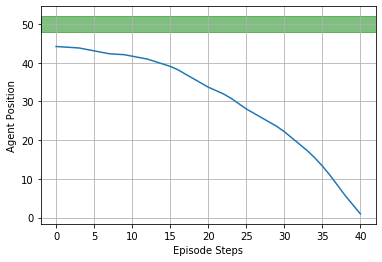

Cumulative Reward per step of Episode 1 is -21.597113541730746


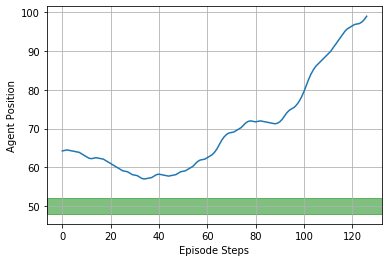

Cumulative Reward per step of Episode 2 is -28.987285520972275


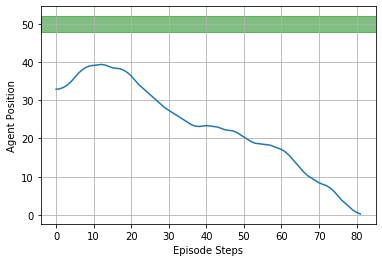

Cumulative Reward per step of Episode 3 is -15.640336375418908


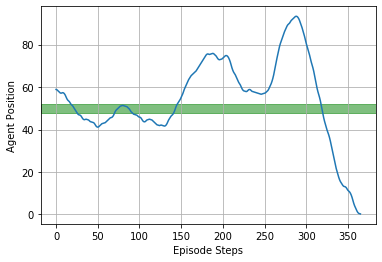

Cumulative Reward per step of Episode 4 is -34.034405101429336


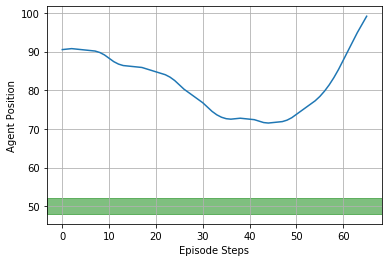

Cumulative Reward per step of Episode 5 is -23.988720195939564


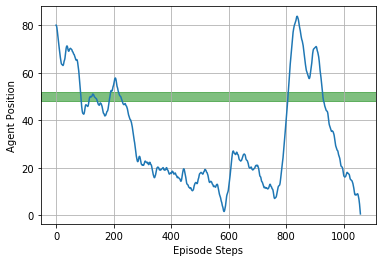

Cumulative Reward per step of Episode 6 is -18.507232890709975


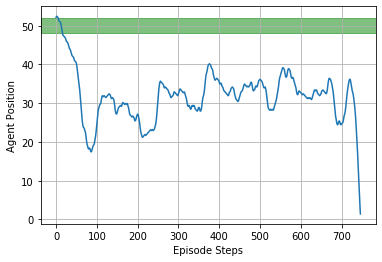

Cumulative Reward per step of Episode 7 is -31.447686151422197


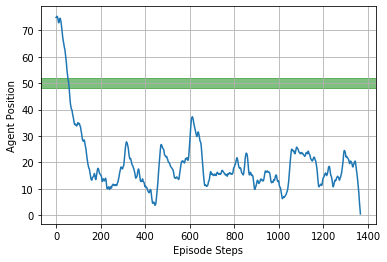

Cumulative Reward per step of Episode 8 is -23.769736466584384


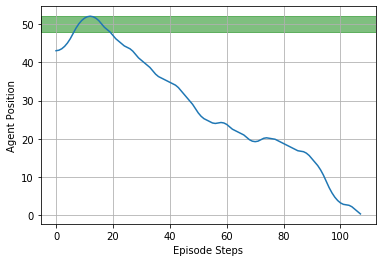

Cumulative Reward per step of Episode 9 is -18.91415458984375


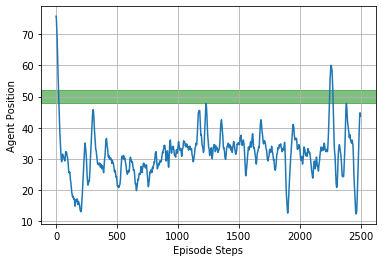

Cumulative Reward per step of Episode 10 is -15.574465836204931


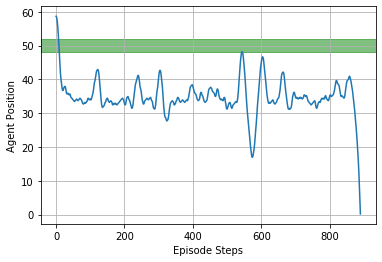

Cumulative Reward per step of Episode 11 is -17.57047519800853


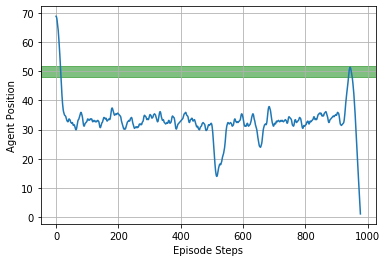

Cumulative Reward per step of Episode 12 is -15.723347650909425


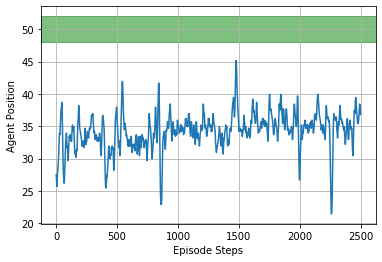

Cumulative Reward per step of Episode 13 is -13.43611728515625


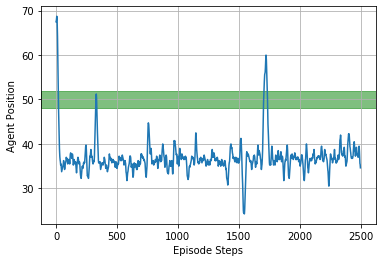

Cumulative Reward per step of Episode 14 is -14.481136645507812


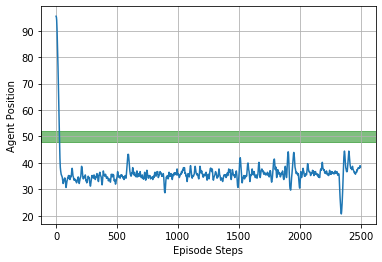

Cumulative Reward per step of Episode 15 is -12.894593245697022


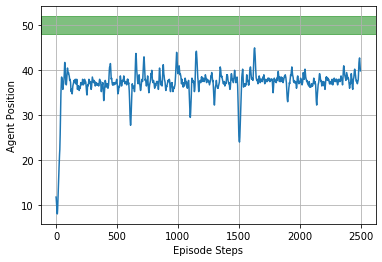

Cumulative Reward per step of Episode 16 is -12.1756470703125


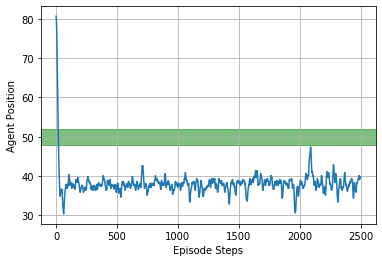

Cumulative Reward per step of Episode 17 is -13.245571810913086


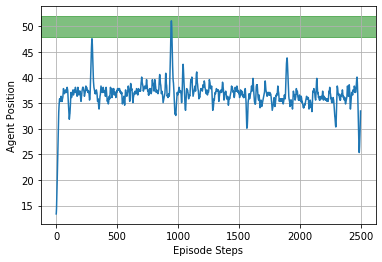

Cumulative Reward per step of Episode 18 is -12.6799236328125


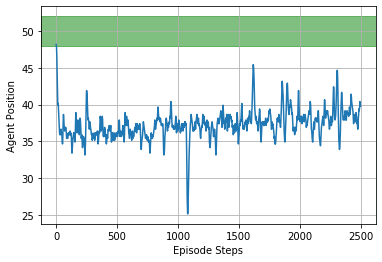

Cumulative Reward per step of Episode 19 is -11.302983193969727


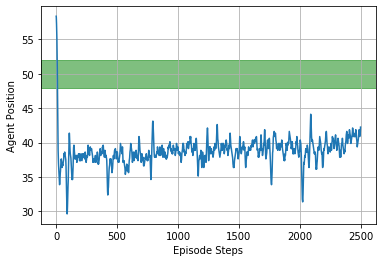

Cumulative Reward per step of Episode 20 is -11.58124428100586


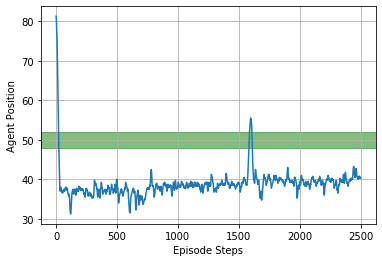

Cumulative Reward per step of Episode 21 is -9.68988062286377


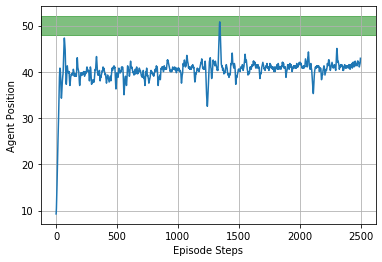

Cumulative Reward per step of Episode 22 is -9.858494885253906


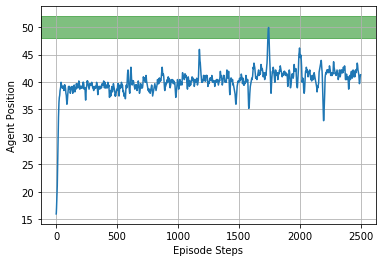

Cumulative Reward per step of Episode 23 is -8.270575439453125


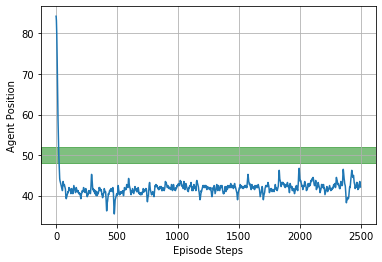

Cumulative Reward per step of Episode 24 is -9.035059978485107


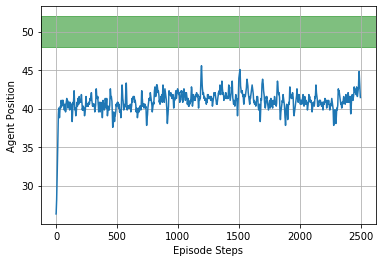

Cumulative Reward per step of Episode 25 is -10.70887993593216


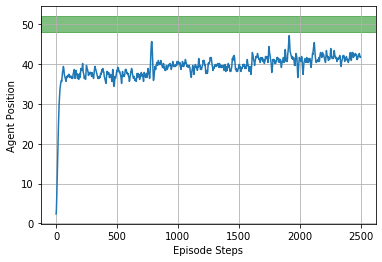

Cumulative Reward per step of Episode 26 is -10.029610495376588


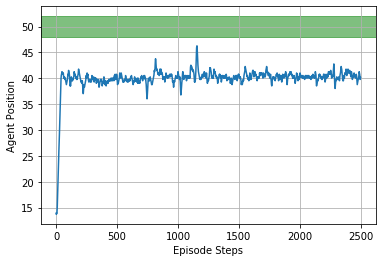

Cumulative Reward per step of Episode 27 is -12.09736117553711


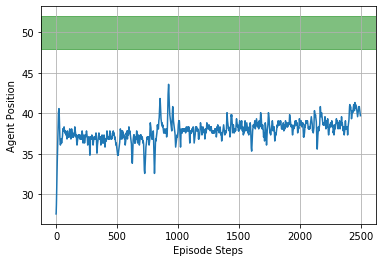

Cumulative Reward per step of Episode 28 is -11.110641397857666


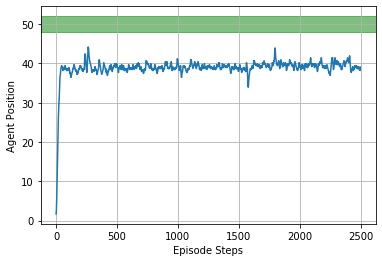

Cumulative Reward per step of Episode 29 is -11.374563716125488


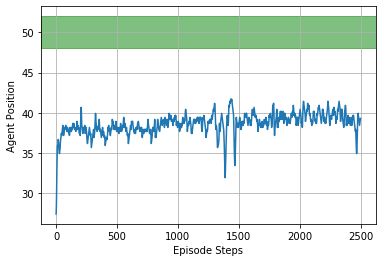

Cumulative Reward per step of Episode 30 is -11.388092138671874


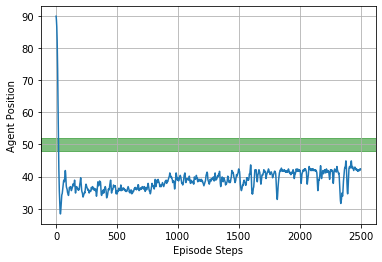

Cumulative Reward per step of Episode 31 is -8.594770629882813


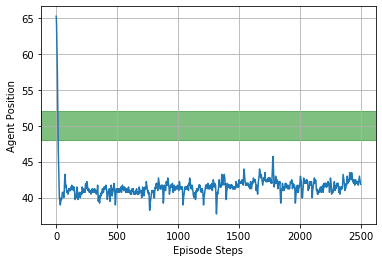

Cumulative Reward per step of Episode 32 is -9.076975625610352


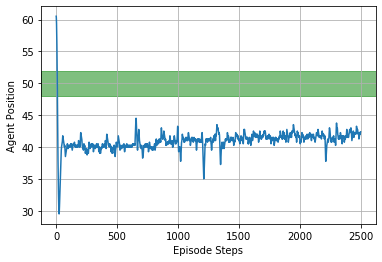

Cumulative Reward per step of Episode 33 is -9.712859619140625


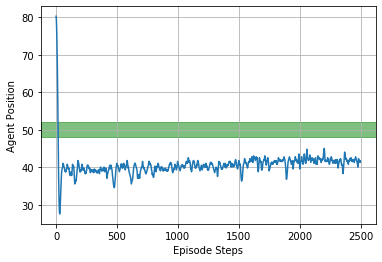

Cumulative Reward per step of Episode 34 is -9.140446494674682


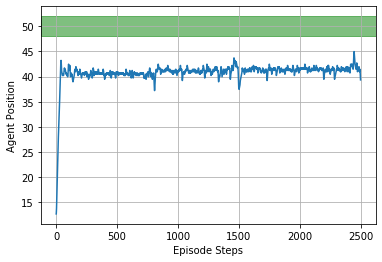

Cumulative Reward per step of Episode 35 is -9.057745361328125


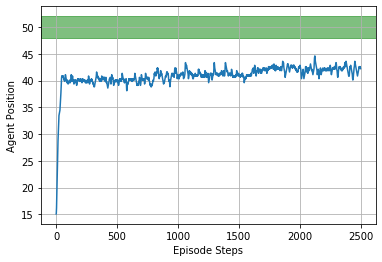

Cumulative Reward per step of Episode 36 is -7.866600048828125


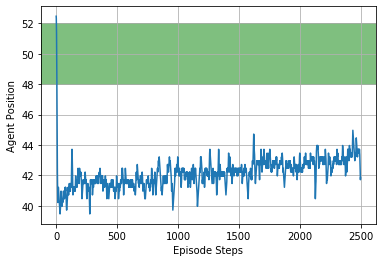

Cumulative Reward per step of Episode 37 is -7.147276312255859


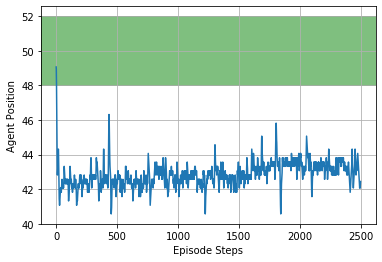

Cumulative Reward per step of Episode 38 is -6.541991772460937


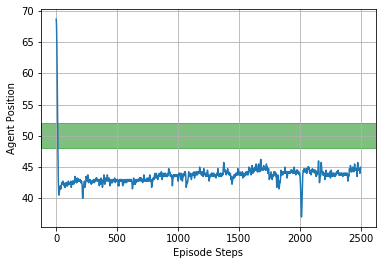

Cumulative Reward per step of Episode 39 is -7.088585858154297


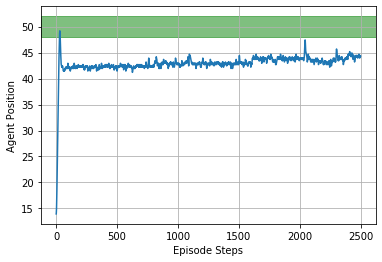

Cumulative Reward per step of Episode 40 is -6.614567541503907


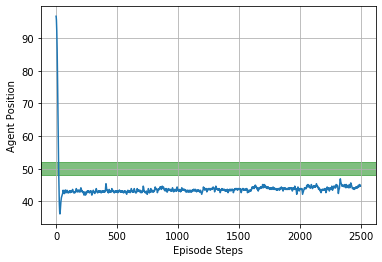

Cumulative Reward per step of Episode 41 is -8.367680151367187


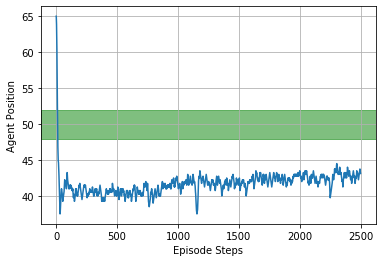

Cumulative Reward per step of Episode 42 is -6.146544689941407


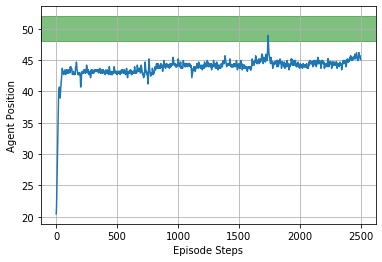

Cumulative Reward per step of Episode 43 is -6.306975787353515


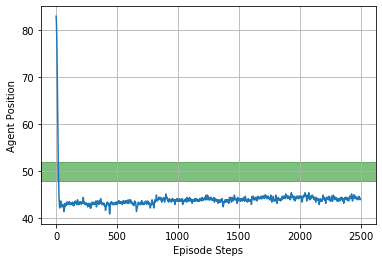

Cumulative Reward per step of Episode 44 is -6.089765246582031


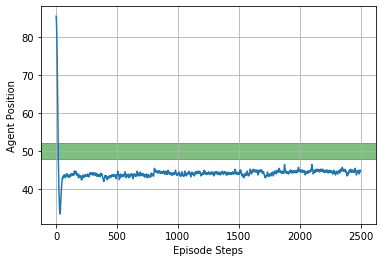

Cumulative Reward per step of Episode 45 is -5.404868560791016


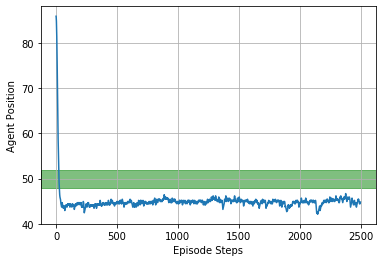

Cumulative Reward per step of Episode 46 is -5.310632726287841


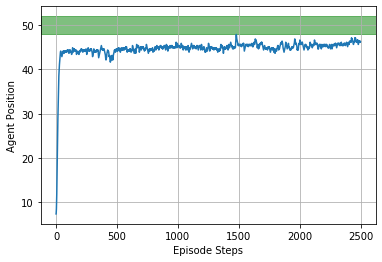

Cumulative Reward per step of Episode 47 is -4.738963909912109


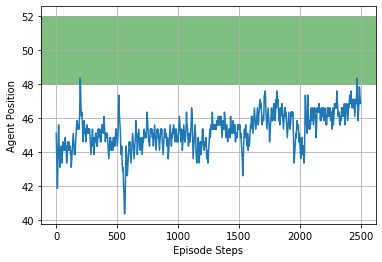

Cumulative Reward per step of Episode 48 is -5.0377765625


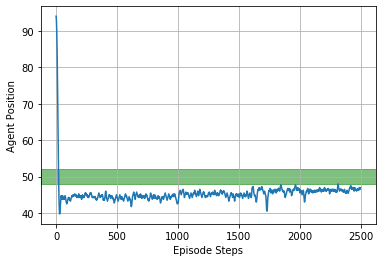

Cumulative Reward per step of Episode 49 is -4.333705480957032


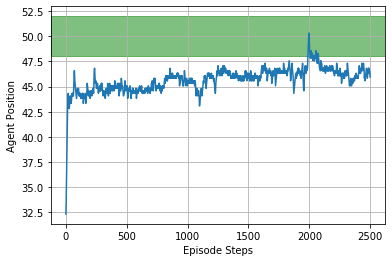

Cumulative Reward per step of Episode 50 is -3.51345361328125


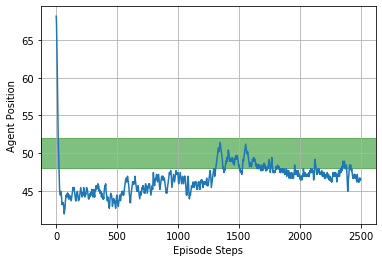

Cumulative Reward per step of Episode 51 is -4.365688092041015


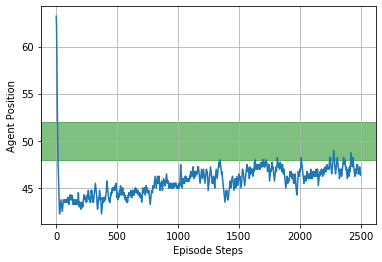

Cumulative Reward per step of Episode 52 is -3.2074451049804686


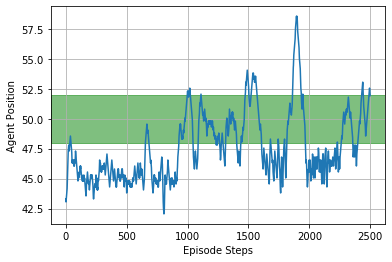

Cumulative Reward per step of Episode 53 is -1.7212828216552734


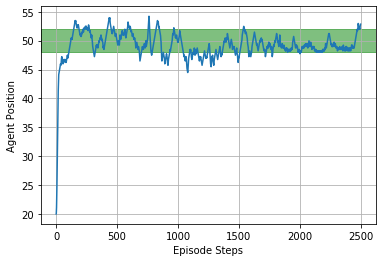

Cumulative Reward per step of Episode 54 is -3.451728125


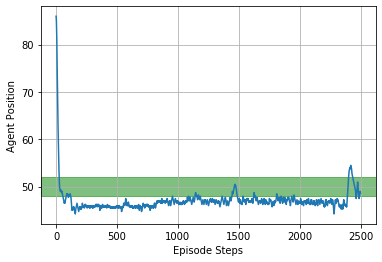

Cumulative Reward per step of Episode 55 is -4.562777307128906


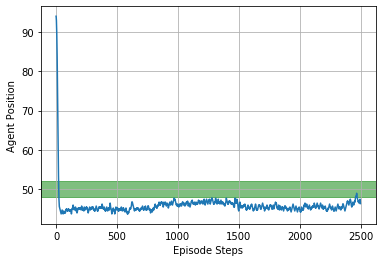

Cumulative Reward per step of Episode 56 is -5.609010384368896


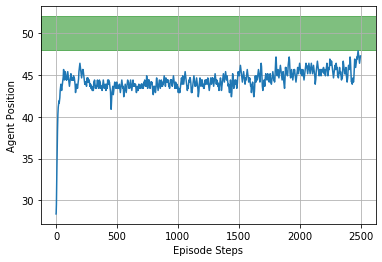

Cumulative Reward per step of Episode 57 is -3.4769403686523437


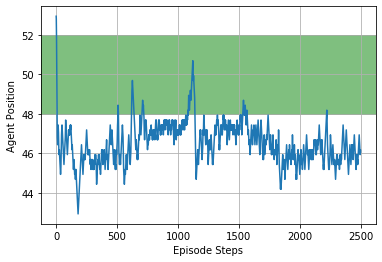

Cumulative Reward per step of Episode 58 is -3.050741375732422


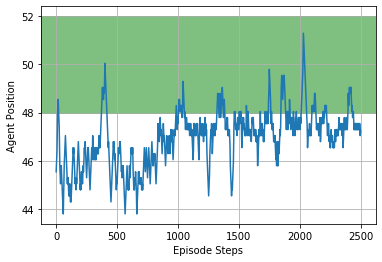

Cumulative Reward per step of Episode 59 is -4.1207925193786625


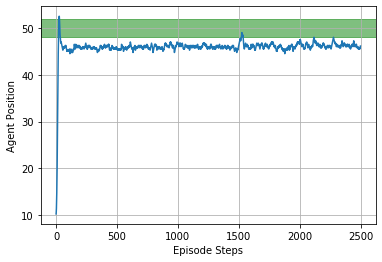

Cumulative Reward per step of Episode 60 is -6.291636291503906


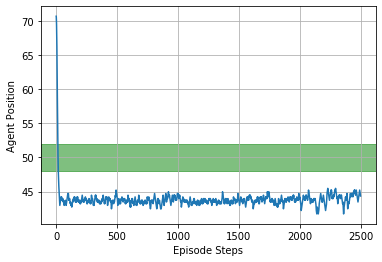

Cumulative Reward per step of Episode 61 is -6.061083874511719


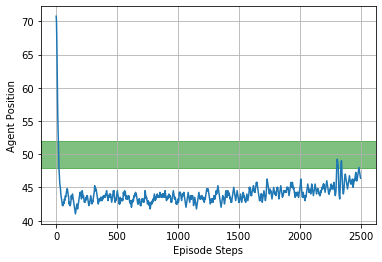

Cumulative Reward per step of Episode 62 is -5.125130786132813


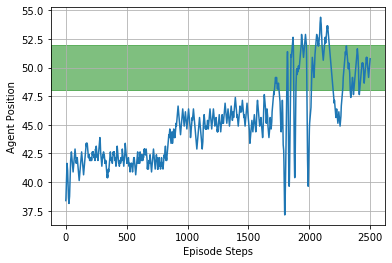

Cumulative Reward per step of Episode 63 is -1.5072564453125


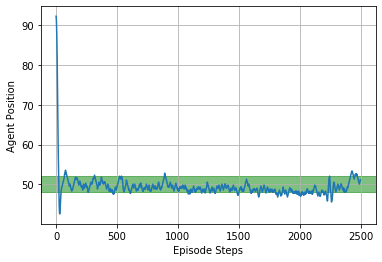

Cumulative Reward per step of Episode 64 is -2.409883135986328


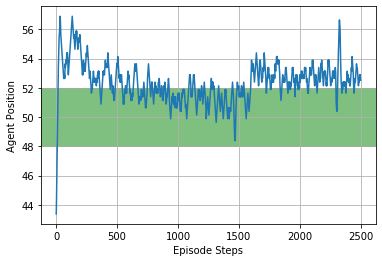

Cumulative Reward per step of Episode 65 is -1.2255351440429687


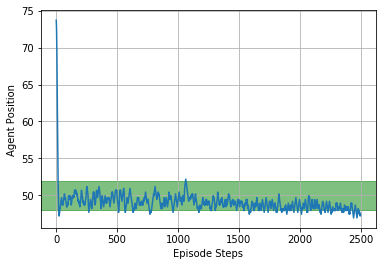

Cumulative Reward per step of Episode 66 is -4.5039452392578125


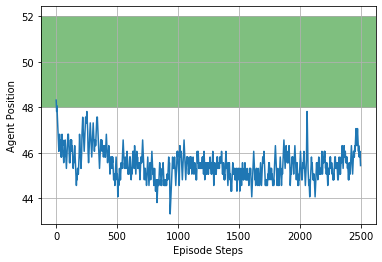

Cumulative Reward per step of Episode 67 is -4.568738348388671


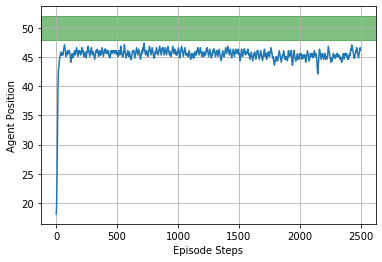

Cumulative Reward per step of Episode 68 is -5.695117604064942


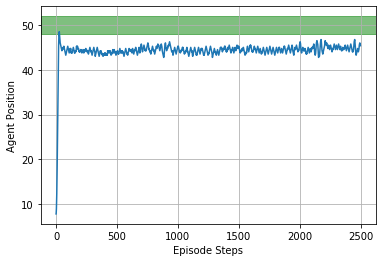

Cumulative Reward per step of Episode 69 is -6.221424395751953


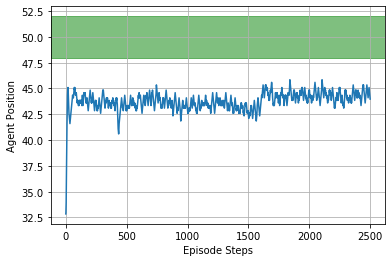

Cumulative Reward per step of Episode 70 is -5.975636096191407


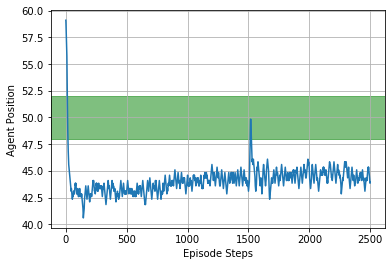

Cumulative Reward per step of Episode 71 is -5.5733464904785155


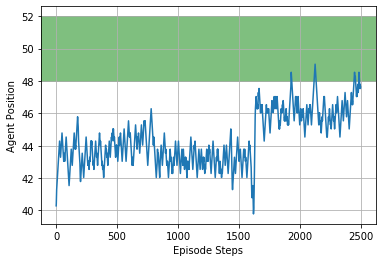

Cumulative Reward per step of Episode 72 is -2.502716162109375


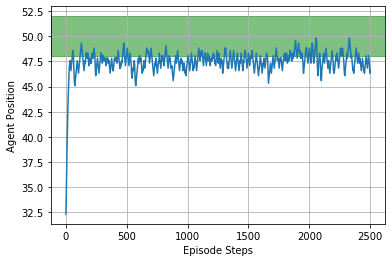

Cumulative Reward per step of Episode 73 is -2.0577130615234376


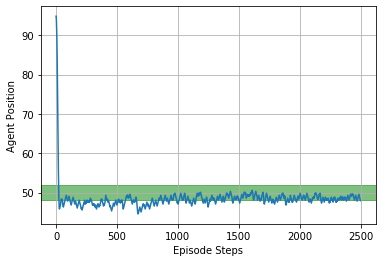

Cumulative Reward per step of Episode 74 is -1.2794348693847657


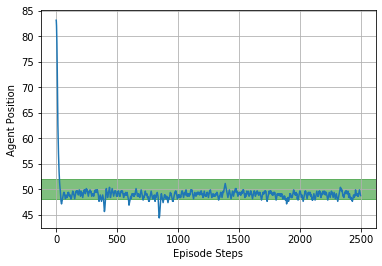

Cumulative Reward per step of Episode 75 is -1.8061322387695313


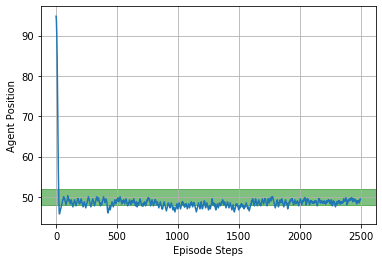

Cumulative Reward per step of Episode 76 is -2.2758568572998046


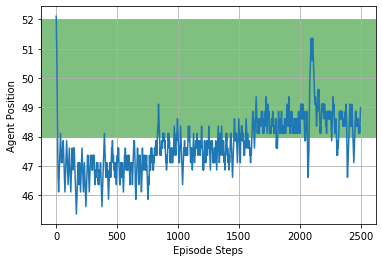

Cumulative Reward per step of Episode 77 is -2.7809955627441405


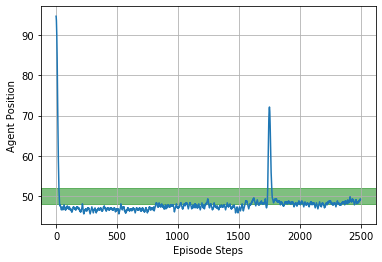

Cumulative Reward per step of Episode 78 is -1.7511445190429686


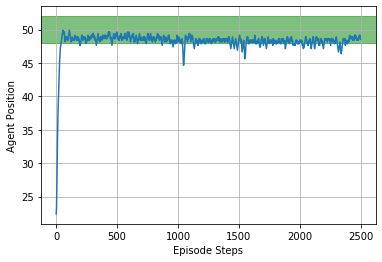

Cumulative Reward per step of Episode 79 is -2.106803021240234


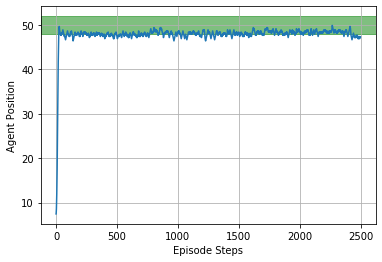

Cumulative Reward per step of Episode 80 is -2.7141929595947265


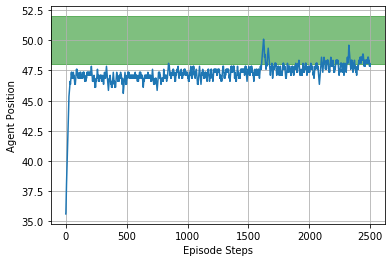

Cumulative Reward per step of Episode 81 is -2.0004013977050783


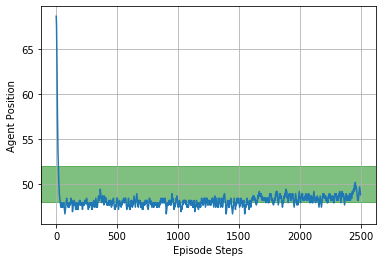

Cumulative Reward per step of Episode 82 is -1.2604150024414063


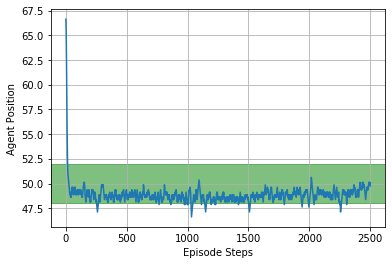

Cumulative Reward per step of Episode 83 is -1.0296328201293945


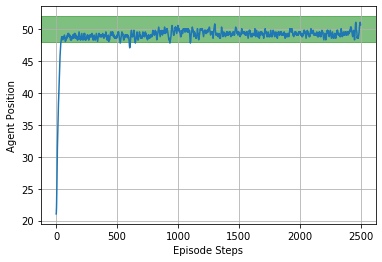

Cumulative Reward per step of Episode 84 is -1.6899771739959717


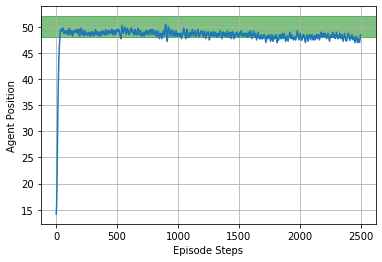

Cumulative Reward per step of Episode 85 is -3.304188232421875


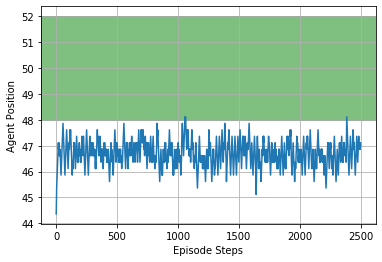

Cumulative Reward per step of Episode 86 is -4.313224407958985


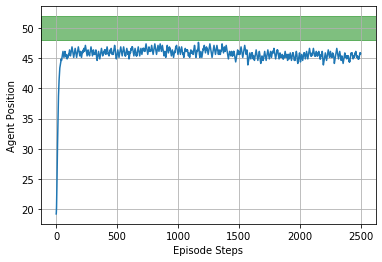

Cumulative Reward per step of Episode 87 is -3.99856240234375


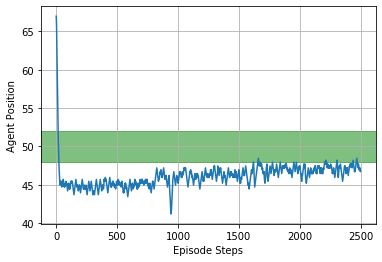

Cumulative Reward per step of Episode 88 is -2.543236267089844


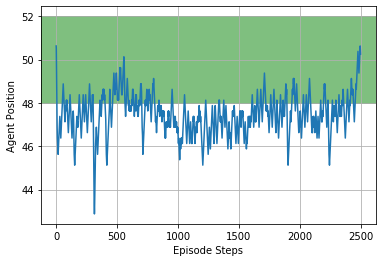

Cumulative Reward per step of Episode 89 is -2.86692109375


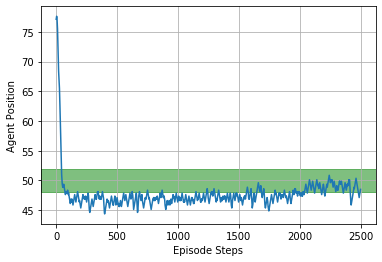

Cumulative Reward per step of Episode 90 is -1.2426442749023439


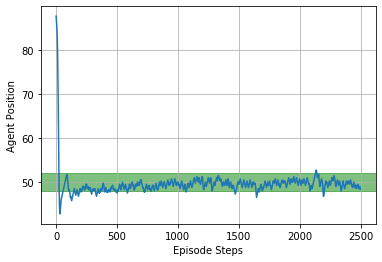

Cumulative Reward per step of Episode 91 is -1.1373352172851563


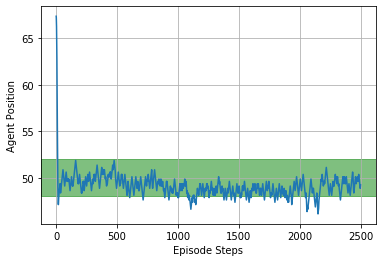

Cumulative Reward per step of Episode 92 is -0.8937856536865234


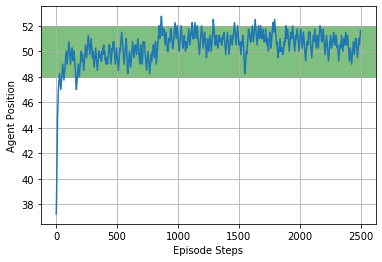

Cumulative Reward per step of Episode 93 is -0.7256991149902344


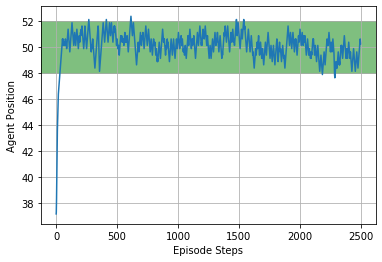

Cumulative Reward per step of Episode 94 is -0.9395797729492188


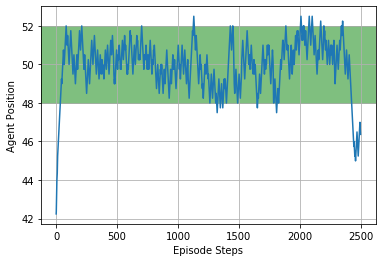

Cumulative Reward per step of Episode 95 is -7.438807720947266


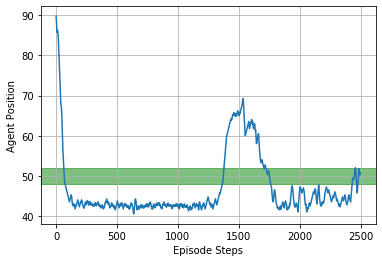

Cumulative Reward per step of Episode 96 is -5.9519736877441405


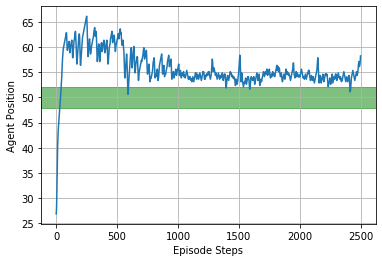

Cumulative Reward per step of Episode 97 is -2.3070687591552734


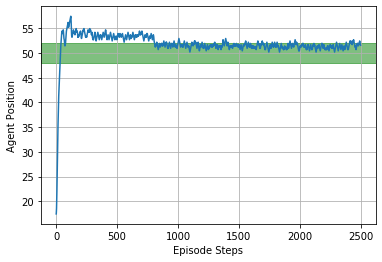

Cumulative Reward per step of Episode 98 is -0.8994124389648438


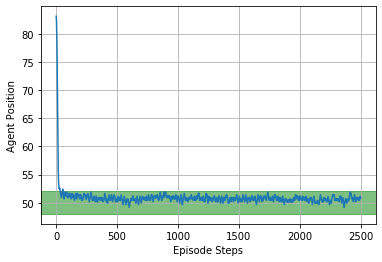

Cumulative Reward per step of Episode 99 is -0.6719604125976563


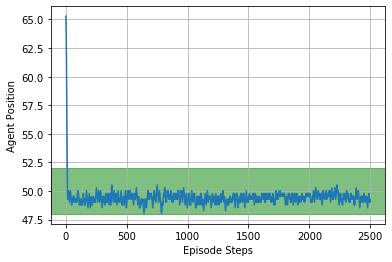

Cumulative Reward per step of Episode 100 is -1.0241074768066407


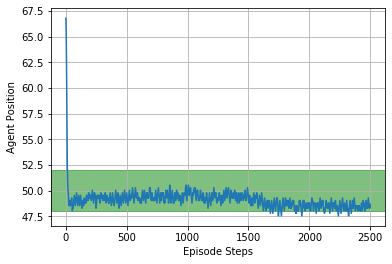

Cumulative Reward per step of Episode 101 is -2.01083095703125


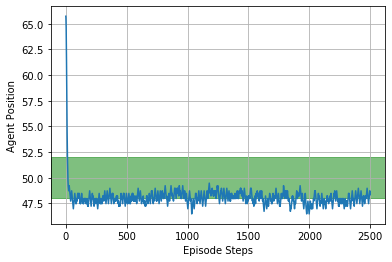

Cumulative Reward per step of Episode 102 is -1.2793723358154296


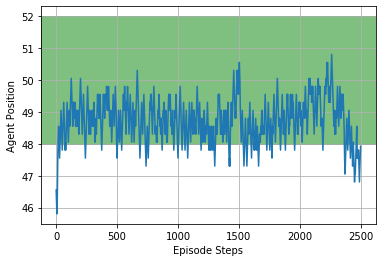

Cumulative Reward per step of Episode 103 is -1.7790191162109374


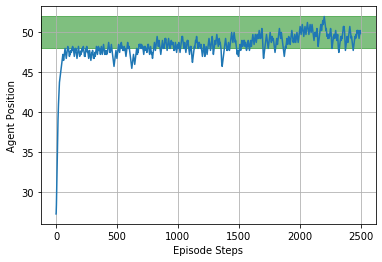

Cumulative Reward per step of Episode 104 is -68.21929834783077


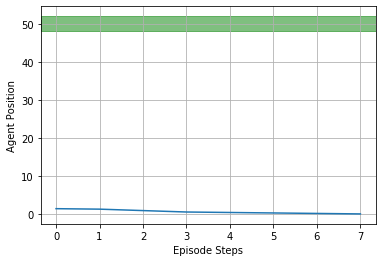

Cumulative Reward per step of Episode 105 is -1.1372755876541139


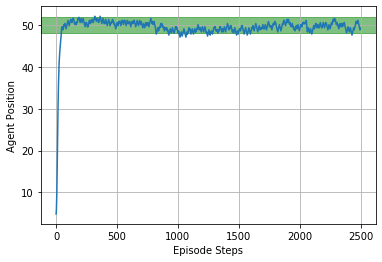

Cumulative Reward per step of Episode 106 is -0.91640966796875


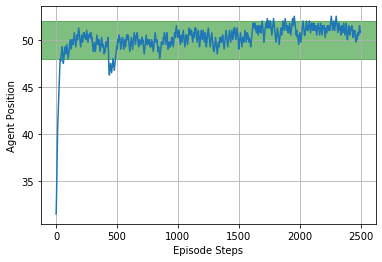

Cumulative Reward per step of Episode 107 is -1.1632404052734375


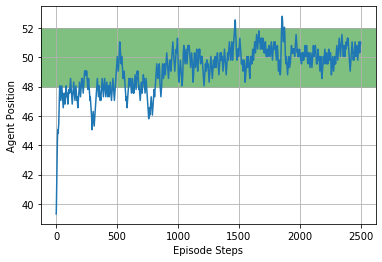

Cumulative Reward per step of Episode 108 is -1.39440576171875


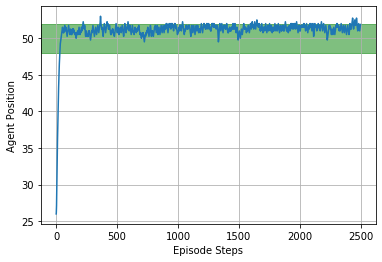

Cumulative Reward per step of Episode 109 is -0.953125732421875


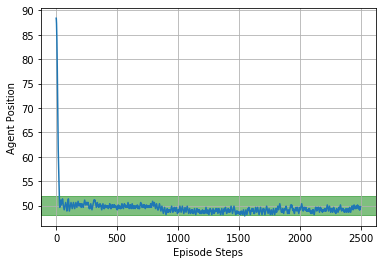

Cumulative Reward per step of Episode 110 is -0.886420263671875


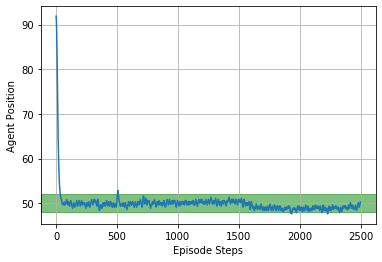

Cumulative Reward per step of Episode 111 is -1.125415887451172


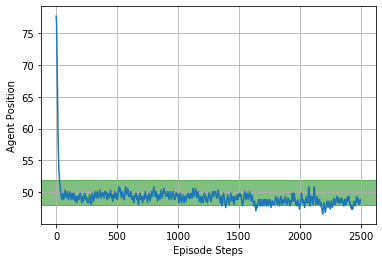

Cumulative Reward per step of Episode 112 is -0.7716131122589112


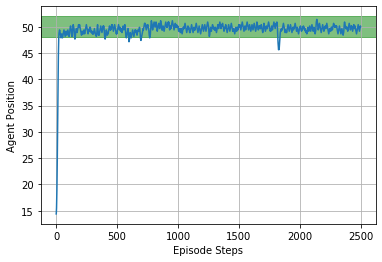

Cumulative Reward per step of Episode 113 is -0.5006473358154296


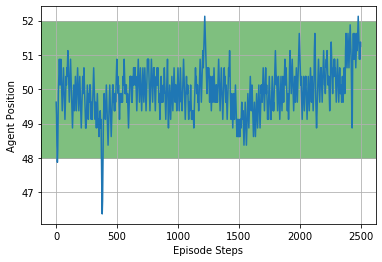

Cumulative Reward per step of Episode 114 is -0.7443768676757813


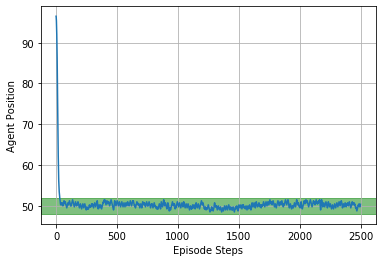

Cumulative Reward per step of Episode 115 is -0.715742919921875


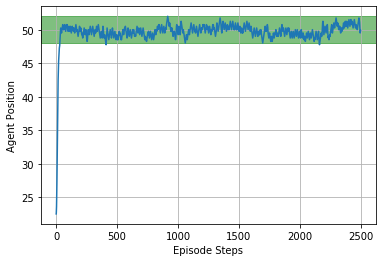

Cumulative Reward per step of Episode 116 is -0.8016833343505859


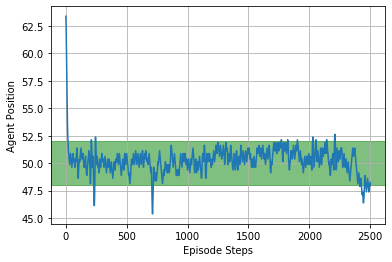

Cumulative Reward per step of Episode 117 is -1.8834215183258056


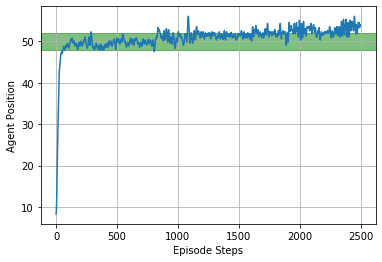

Cumulative Reward per step of Episode 118 is -1.7724380432128906


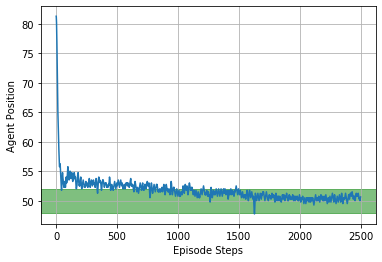

Cumulative Reward per step of Episode 119 is -1.3161428466796874


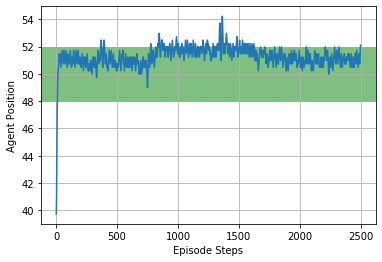

Cumulative Reward per step of Episode 120 is -0.9183102416992187


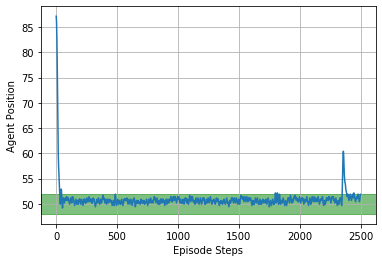

Cumulative Reward per step of Episode 121 is -0.8609135284423828


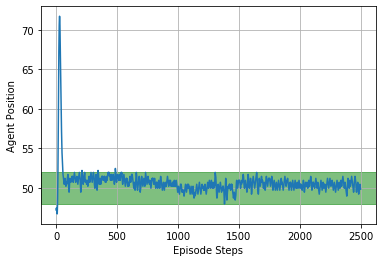

Cumulative Reward per step of Episode 122 is -0.5373307647705078


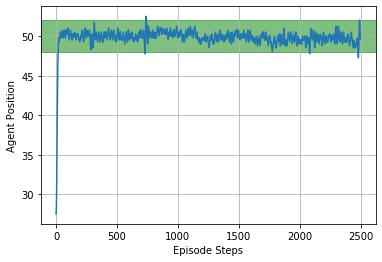

Cumulative Reward per step of Episode 123 is -0.6266985534667969


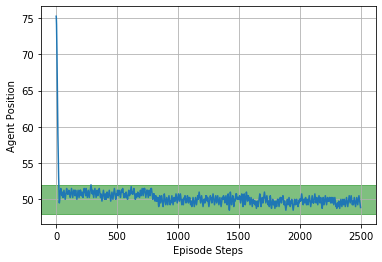

Cumulative Reward per step of Episode 124 is -1.8941153564453126


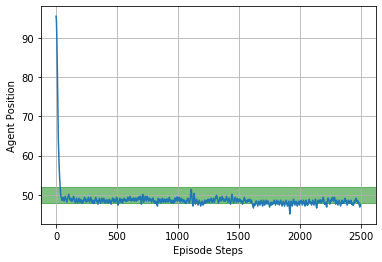

Cumulative Reward per step of Episode 125 is -1.9720085693359375


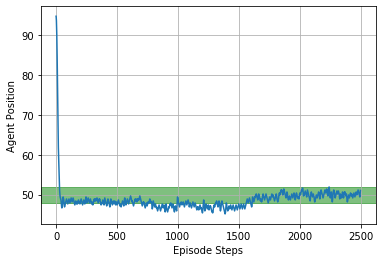

Cumulative Reward per step of Episode 126 is -2.392475213623047


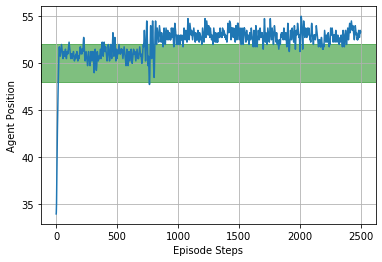

Cumulative Reward per step of Episode 127 is -3.3094577238082885


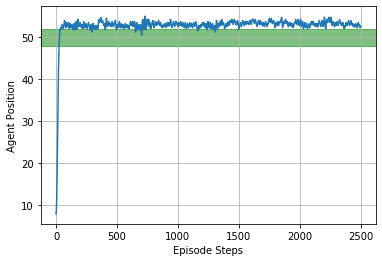

Cumulative Reward per step of Episode 128 is -2.085898083496094


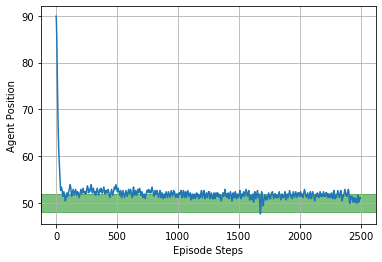

Cumulative Reward per step of Episode 129 is -1.029835400390625


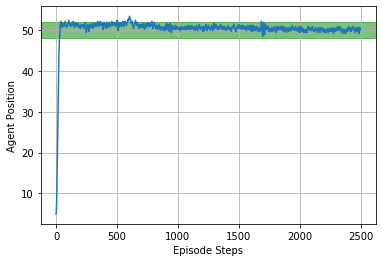

Cumulative Reward per step of Episode 130 is -0.70446044921875


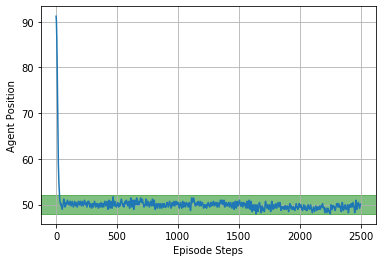

Cumulative Reward per step of Episode 131 is -0.6680336639404297


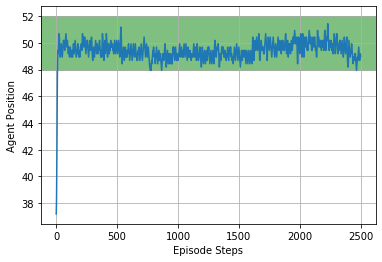

Cumulative Reward per step of Episode 132 is -0.8799853271484375


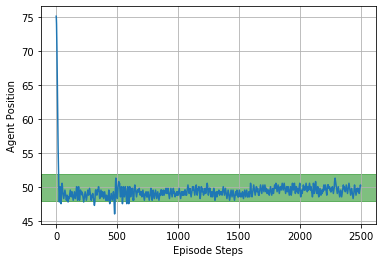

Cumulative Reward per step of Episode 133 is -0.8994331909179687


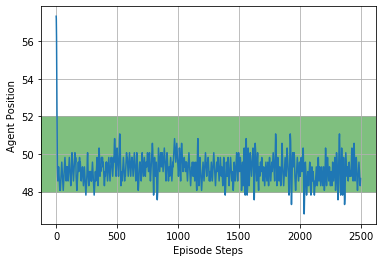

Cumulative Reward per step of Episode 134 is -1.7214153747558594


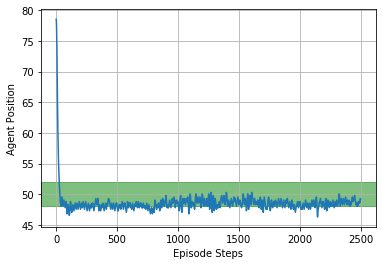

Cumulative Reward per step of Episode 135 is -1.4430373512268067


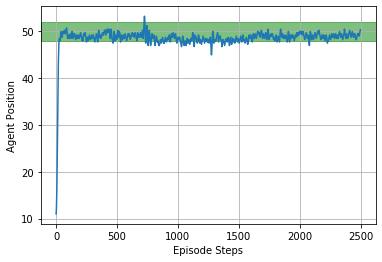

Cumulative Reward per step of Episode 136 is -1.2534421203613282


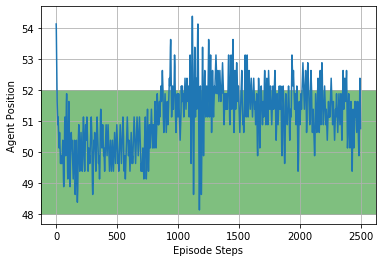

Cumulative Reward per step of Episode 137 is -2.0160449645996095


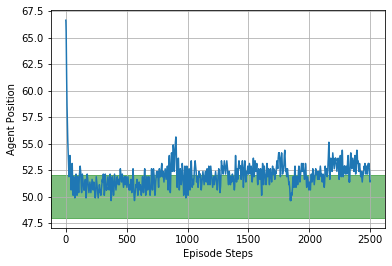

Cumulative Reward per step of Episode 138 is -1.2060613459587097


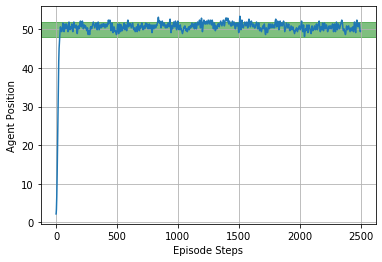

Cumulative Reward per step of Episode 139 is -1.2177482971191407


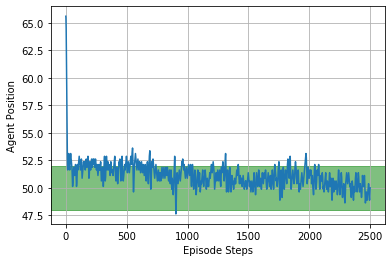

Cumulative Reward per step of Episode 140 is -0.9697873962402344


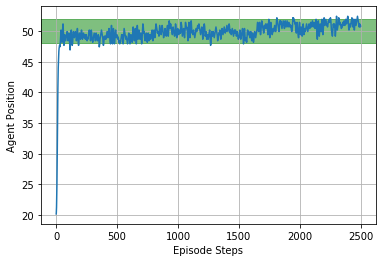

Cumulative Reward per step of Episode 141 is -2.911020343017578


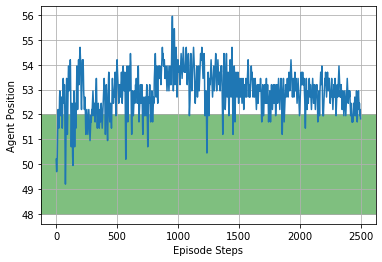

Cumulative Reward per step of Episode 142 is -1.907623779296875


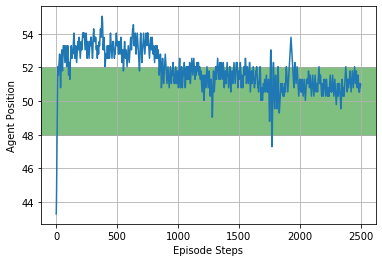

Cumulative Reward per step of Episode 143 is -1.4127490127563476


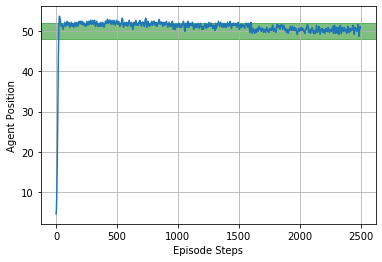

Cumulative Reward per step of Episode 144 is -30.15127924510411


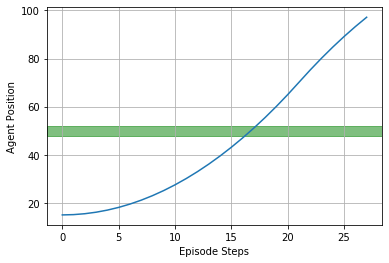

Cumulative Reward per step of Episode 145 is -0.9600710330963135


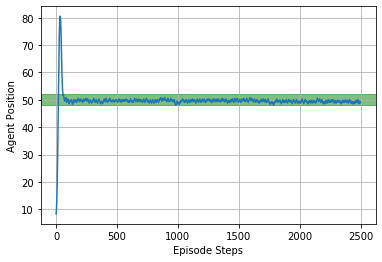

Cumulative Reward per step of Episode 146 is -1.1211665161132813


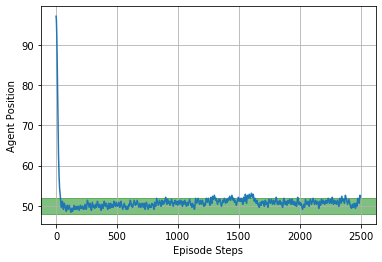

Cumulative Reward per step of Episode 147 is -2.547071708679199


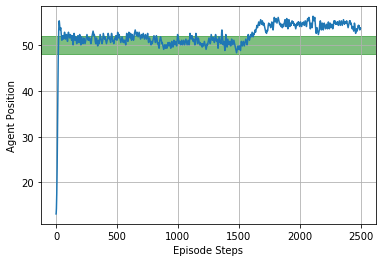

Cumulative Reward per step of Episode 148 is -2.2236126892089842


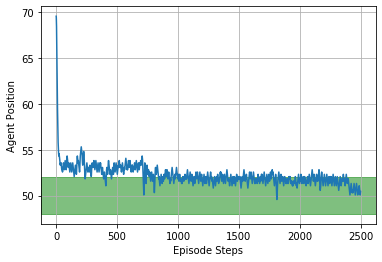

Cumulative Reward per step of Episode 149 is -1.097952703857422


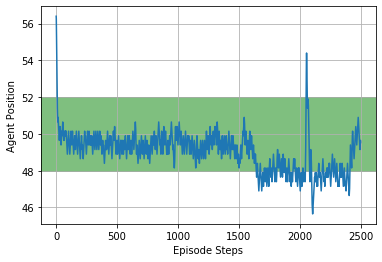

In [5]:
train_logs = agent.train(visualize=True)

In [6]:
test_logs = agent.test(visualize=False) # set visualize to True for visualization during testing 


tested for 20 episodes


Text(0, 0.5, 'Cumulative reward per step')

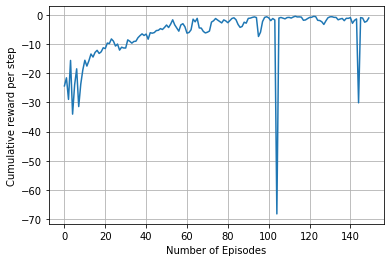

In [7]:
plt.plot(train_logs['cum_rew'])
plt.grid()
plt.xlabel("Number of Episodes")
plt.ylabel("Cumulative reward per step")

 Mean cumulative reward of entire testing is -0.39370500092506405
 Variance of cumulative reward over entire testing is 0.051456868429150246


Text(0, 0.5, 'Cumulative reward per step')

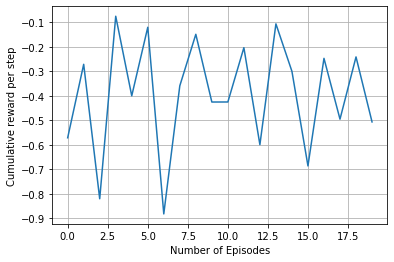

In [8]:
print(" Mean cumulative reward of entire testing is " + str(np.array(test_logs['cum_rew']).mean()))
print(" Variance of cumulative reward over entire testing is " + str(np.array(test_logs['cum_rew']).var()))
plt.plot(test_logs['cum_rew'])
plt.grid()
plt.xlabel("Number of Episodes")
plt.ylabel("Cumulative reward per step")

Result Analysis :

1) Plots of Cumulative reward per step v/s Number of episodes clearly indicate the learning policy, i.e. the agent learns to take the action such that it stays at the center of the surface.

2) To show that the model has not overfit, Testing was conducted for 20 episodes and respective cumulative reward per step vs Number of Episodes is plotted. The mean and variance of testing shows that the agent is stable.
